In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from recast import Model
import tensorflow as tf

### Chargement

In [2]:
file = open("data/data.pkl", "rb")
data = pickle.load(file)
t_end = 100
data[0].head()

,t,m,parent
id,,,
0,0.708637,0.364044,-1
1,0.708682,0.094708,0
2,2.350490,0.970297,-1
3,3.455362,0.124873,-1
4,5.179003,0.077304,-1


### Préparation des données

In [3]:
arrival_times = []
for df in data:
    arrival_times.append(df.t.to_numpy())

In [4]:
seq_lengths = [len(times) for times in arrival_times]
inter_times_list = [np.diff(times, prepend=0, append=t_end)
                    for times in arrival_times]
inter_times = np.asarray([np.pad(inter_times, (0, np.max(seq_lengths) - size))
        for size, inter_times in zip(seq_lengths, inter_times_list)])
inter_times = tf.Variable(inter_times, dtype=tf.float32)

In [5]:
print(inter_times.shape)
print(np.max(inter_times))
print(np.max(seq_lengths))

(100, 300)
9.177464
299


In [6]:
context_size = 32
epochs = 40
model = Model(context_size)
model.fit(epochs, inter_times, seq_lengths, t_end)

Loss at epoch 0: -1.16
Loss at epoch 10: -5.62
Loss at epoch 20: -5.88
Loss at epoch 30: -5.93
Loss at epoch 40: -5.97


In [7]:
batch_size=10
t_end = 100
generated = model.sample(batch_size, t_end)

In [8]:
np.mean(seq_lengths)

183.54

In [9]:
generated_data = pd.DataFrame(generated).T
generated_data.shape

(77, 10)

In [10]:
# dernier temps d'arrivée pour chaque séquence
generated_data.iloc[-1]

0    363.679849
1    175.616942
2    251.710057
3    195.242501
4    159.650867
5    219.320569
6    134.951233
7    106.278184
8    153.434742
9    164.310578
Name: 76, dtype: float64

In [11]:
# première séquence
generated_data.iloc[-10:, 0]

67    279.172289
68    281.499273
69    359.087018
70    359.145008
71    360.878835
72    361.818864
73    363.558782
74    363.652752
75    363.678645
76    363.679849
Name: 0, dtype: float64

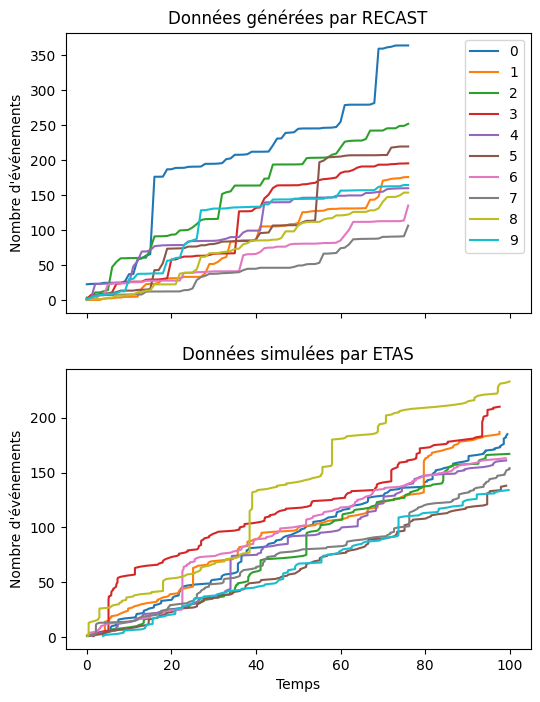

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
generated_data.plot(ax=axes[0])
axes[0].set_title("Données générées par RECAST")
axes[0].set_ylabel("Nombre d'événements")

for df in data[:10]:
    axes[1].plot(df.t, df.index + 1)
axes[1].set_title("Données simulées par ETAS")
axes[1].set_xlabel("Temps")
axes[1].set_ylabel("Nombre d'événements")
plt.show()

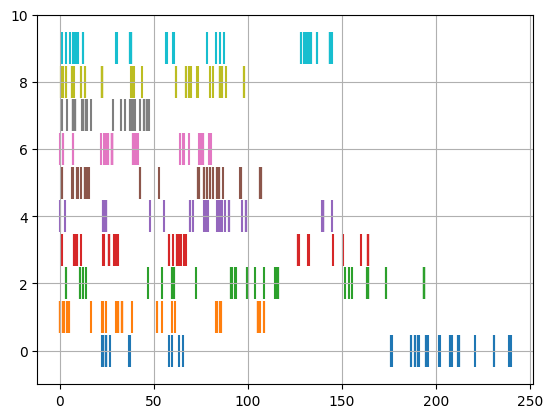

In [13]:
for i in range(generated.shape[0]):
    arr = generated[i, :50]
    plt.scatter(arr, np.ones_like(arr) * i, marker="|", s=500)
plt.grid()
plt.ylim([-1, generated.shape[0]])
plt.show()

### Regénération et comparaison avec des histogrammes

In [14]:
batch_size=1000
t_end = 100
arrival_times = model.sample(batch_size, t_end)

In [15]:
seq_lengths = (arrival_times < t_end).sum(axis=-1)
seq_lengths[:10]

array([25, 37, 55, 37, 53, 38, 38,  8, 57, 42])

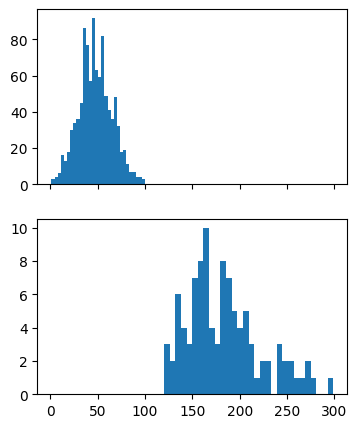

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
axes[0].hist(seq_lengths, bins=30)

seq_lengths_etas = [df.shape[0] for df in data]
axes[1].hist(seq_lengths_etas, bins=30)

plt.show()

Les histogrammes ne correspondent pas.